In [220]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import astropy as py
import pyspeckit
import astropy.units as u
import pandas as pd

from iminuit.cost import LeastSquares
from iminuit import Minuit

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import constants
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.stats import akaike_info_criterion

from scipy import constants as const
from scipy import optimize
from scipy.stats import chisquare
from scipy.stats import norm
from scipy.stats import gaussian_kde

from RegscorePy.aic import aic

from spectral_cube import SpectralCube

from pvextractor import extract_pv_slice, Path, PathFromCenter

from pyspeckit.cubes.mapplot import MapPlotter

%matplotlib inline
plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'xx-large'
plt.rcParams['ytick.labelsize'] = 'xx-large'
plt.rcParams.update({"text.usetex": False,
                     "font.family": "serif",
                     'xtick.direction': 'out',
                     'ytick.direction': 'in'})

my_figsize = (5, 5)

In [221]:
rms = 0.000742

vlsr = 8.3

# Gaussian

In [222]:
def Gaussian(x, A, mu, width):
    return A*np.exp(-(x-mu)**2/(2.0*width**2))

In [223]:
def Gaussian_2comp(x, A1, mu1, width1, A2, mu2, width2):
    return A1*np.exp(-(x-mu1)**2/(2.0*width1**2)) + A2*np.exp(-(x-mu2)**2/(2.0*width2**2))

In [224]:
def Gaussian_3comp(x, A1, mu1, width1, A2, mu2, width2, A3, mu3, width3):
    return A1*np.exp(-(x-mu1)**2/(2.0*width1**2)) + A2*np.exp(-(x-mu2)**2/(2.0*width2**2)) + A3*np.exp(-(x-mu3)**2/(2.0*width3**2))

# Load Cube

In [225]:
#file_cube = 'Documents/H13CO/B335_Combine_H13COp_32_rob05_2sigma_self_clean.fits'
file_cube = 'Documents/SO/B335_SO_medsub.fits'

#freq_line = rest_freq = 260.25533900 * u.GHz
freq_line = rest_freq = 261.84368400 * u.GHz

Cube = SpectralCube.read(file_cube).with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                                  rest_value=rest_freq)

In [226]:
def load_myCube( file_in):
    cube = pyspeckit.Cube(file_in)
    cube.xarr.refX = freq_line
    cube.xarr.velocity_convention = 'radio'
    cube.xarr.convert_to_unit('km/s')
    return cube

In [227]:
cube = load_myCube(file_cube)

In [228]:
cube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                 1200                                                  
NAXIS2  =                 1200                                                  
NAXIS3  =                  170                                                  
BMAJ    =   3.444986264573E-05                                                  
BMIN    =   2.573787215642E-05                                                  
BPA     =  -5.980397630356E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'B335    '                                                            
BUNIT   = 'beam-1 Jy'          / Brightness (pixel) unit                        
ALTRVAL =   2.365999999998E+

In [575]:
x = xpix = 586
y = ypix = 612

Spec = cube.get_spectrum(ypix, xpix)

In [576]:
vmin = 2.5; vmax = 13
tpeak_min = 3*rms; tpeak_max = 200e-3
dv_min = 0.05; dv_max = 6.0
F = False
T = True

In [578]:
#guesses = np.array([10e-3, 6.2, 1.5, 25e-3, 6.8, 0.3, 25e-3, 7.8, 1])
#guesses = [2e-3, 8.32, 0.2, 2e-3, 8, 0.5, 0.004, 8.7, 1.0, 0.006, 11, 1.0]
#guesses = [23e-3, 8.0, 0.7, 15e-3, 6.7, 0.6, 7.0e-3, 5.2, 1.0]
#guesses = [0.012, 8.18, 1, 0.01, 10.3, 0.8]
guesses = [ 0.03, 7.7, 1, 0.005, 8.2, 2, 0.02, 9, 1]
#guesses = [0.015, 8.3, 1]

Spec.specfit(fittype='gaussian', guesses=guesses,
             limits=[(tpeak_min,tpeak_max), (vmin,vmax), (dv_min,dv_max), (tpeak_min,tpeak_max), (vmin,vmax), (dv_min,dv_max), (tpeak_min,tpeak_max), (vmin,vmax), (dv_min,dv_max)],
            limited=[(T,T), (T,T), (T,T), (T,T), (T,T), (T,T), (T,T), (T,T), (T,T)])

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,170 [pyspeckit.spectrum.interactive]


support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


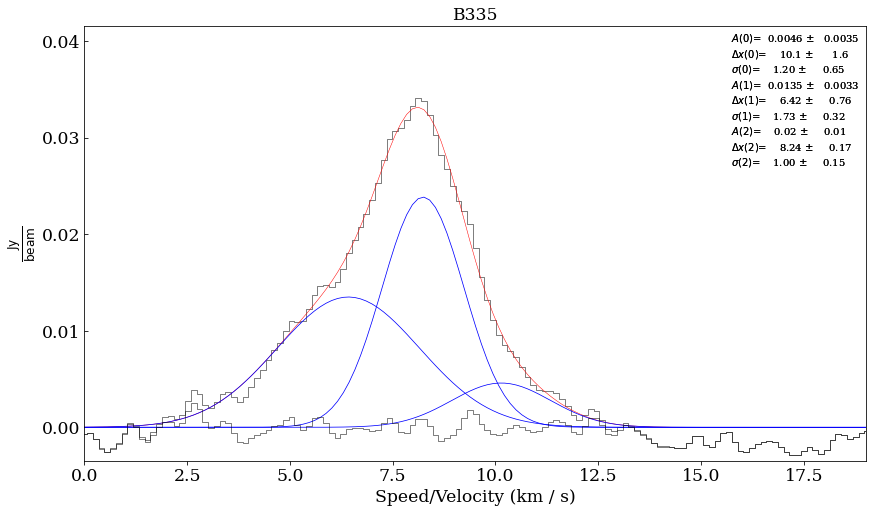

In [579]:
Spec.plotter()
Spec.specfit.plot_fit()
Spec.specfit.plot_components()
Spec.specfit.plotresiduals(axis=Spec.plotter.axis, clear=False, label=False)
plt.xlim(0, 19)
plt.savefig('Documents/Figures/Fit_SO_3comp_report.pdf', dpi=200)

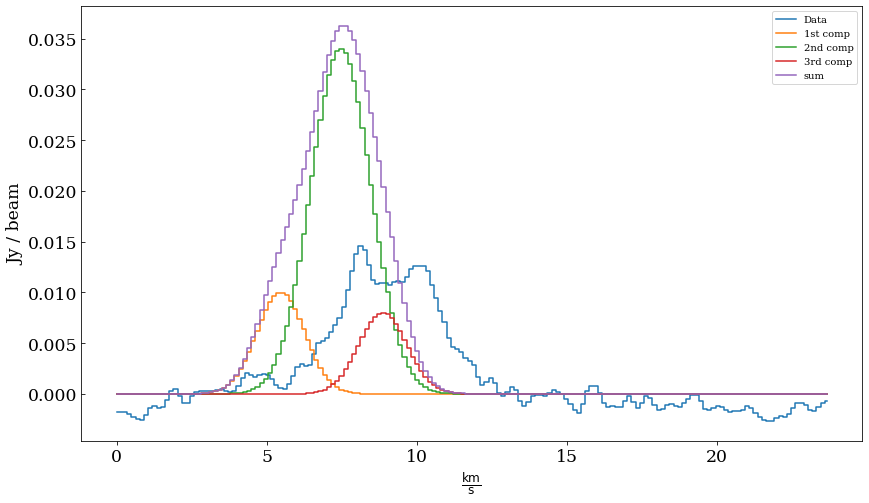

In [233]:
test_JEP = Gaussian(Cube.spectral_axis.value, 0.01, 5.4, 0.8)
test_JEP1 = Gaussian(Cube.spectral_axis.value, 0.034, 7.4, 1.)
test_JEP2 = Gaussian(Cube.spectral_axis.value, 0.008, 8.8, 0.8)

Cube[:,xpix,ypix].quicklook(label='Data')
plt.step(Cube.spectral_axis.value, test_JEP, label='1st comp')
plt.step(Cube.spectral_axis.value, test_JEP1, label='2nd comp')
plt.step(Cube.spectral_axis.value, test_JEP2, label='3rd comp')
plt.step(Cube.spectral_axis.value, test_JEP + test_JEP1 + test_JEP2, label='sum')
plt.legend()

# Load fit parameters for both model

In [529]:
#file_1comp = 'Documents/H13CO/Spec_H13CO_32_1comp_5snr.fits'
#file_2comp = 'Documents/H13CO/Spec_H13CO_32_fit_2comp_5snr.fits'

file_1comp = 'Documents/SO/Spec_SO_fit_5snr_014kms.fits'
file_2comp = 'Documents/SO/Spec_SO_2comp_5snr_slurm.fits'
file_3comp = 'Documents/SO/Spec_SO_3comp_5snr_slurm.fits'

In [530]:
data_1comp, hd_1comp = fits.getdata(file_1comp, header=True)
data_2comp, hd_2comp = fits.getdata(file_2comp, header=True)
data_3comp, hd_3comp = fits.getdata(file_3comp, header=True)

In [542]:
data_3comp[8,xpix,ypix]*2.34

4.302042837423072

In [580]:

test = Gaussian(Cube.spectral_axis.value,
                          data_3comp[0,xpix,ypix],
                          data_3comp[1,xpix,ypix],
                          data_3comp[2,xpix,ypix])
test1 = Gaussian(Cube.spectral_axis.value,
                          data_3comp[3,xpix,ypix],
                          data_3comp[4,xpix,ypix],
                          data_3comp[5,xpix,ypix])
test2 = Gaussian(Cube.spectral_axis.value,
                          data_3comp[6,xpix,ypix],
                          data_3comp[7,xpix,ypix],
                          data_3comp[8,xpix,ypix])

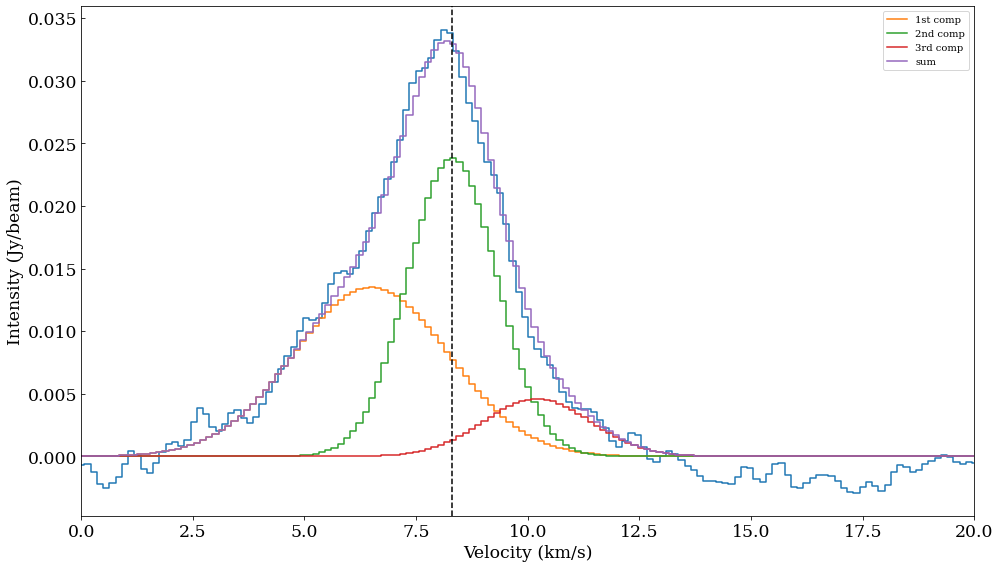

In [581]:
Cube[:,xpix,ypix].quicklook()
plt.step(Cube.spectral_axis.value, test, label='1st comp')
plt.step(Cube.spectral_axis.value, test1, label='2nd comp')
plt.step(Cube.spectral_axis.value, test2, label='3rd comp')
plt.step(Cube.spectral_axis.value, test + test1 + test2 , label='sum')

plt.axvline(8.3, linestyle = 'dashed', color = 'black')
#plt.hlines(0, 0, 25)
plt.xlim(0, 20)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (Jy/beam)')
plt.legend()

plt.tight_layout()

#plt.savefig('Documents/Figures/Broad_SO.pdf', dpi=200)

# Akaike Information Criterion

In [238]:
def chi2(y_data, y_model, err) :
    return np.sum(np.square(y_data - y_model)/err**2)

In [239]:
def AIC(chi2_low, chi2_high, Delta_k = 3.) :
    return 2*Delta_k + chi2_low - chi2_high

In [565]:
chi2_0comp=chi2(Cube[:,x,y].value, 0, rms)

In [566]:
chi2_1comp=chi2(Cube[:,x,y].value, Gaussian(Cube.spectral_axis.value,
                                            data_1comp[0,x,y],
                                            data_1comp[1,x,y],
                                            data_1comp[2,x,y]), rms)

In [567]:
AIC(chi2_1comp, chi2_0comp, Delta_k=3.)

-820.3933872078574

In [568]:
chi2_2comp=chi2(Cube[:,x,y].value,Gaussian_2comp(Cube.spectral_axis.value,
                                                 data_2comp[0,x,y],
                                                 data_2comp[1,x,y],
                                                 data_2comp[2,x,y],
                                                 data_2comp[3,x,y],
                                                 data_2comp[4,x,y],
                                                 data_2comp[5,x,y]), rms)

In [569]:
AIC(chi2_2comp, chi2_1comp, Delta_k=3.)

-10.577217493033743

In [570]:
chi2_3comp=chi2(Cube[:,x,y].value,Gaussian_3comp(Cube.spectral_axis.value,
                                                 data_3comp[0,x,y],
                                                 data_3comp[1,x,y],
                                                 data_3comp[2,x,y],
                                                 data_3comp[3,x,y],
                                                 data_3comp[4,x,y],
                                                 data_3comp[5,x,y],
                                                 data_3comp[6,x,y],
                                                 data_3comp[7,x,y],
                                                 data_3comp[8,x,y]), rms)

In [571]:
AIC(chi2_3comp, chi2_2comp, Delta_k=3.)

-23.919188017749036

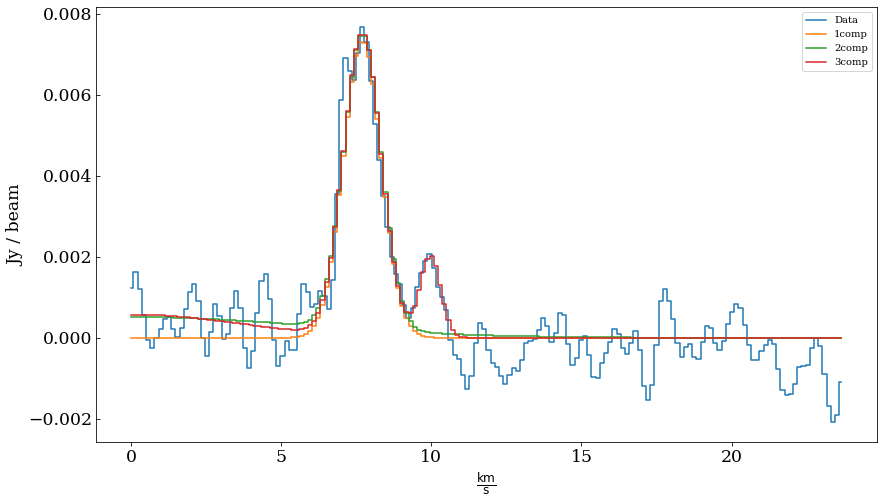

In [573]:
test_1st = Gaussian(Cube.spectral_axis.value,
                    data_1comp[0,xpix,ypix],
                    data_1comp[1,xpix,ypix],
                    data_1comp[2,xpix,ypix])

test_2nd = Gaussian_2comp(Cube.spectral_axis.value,
                          data_2comp[0,xpix,ypix],
                          data_2comp[1,xpix,ypix],
                          data_2comp[2,xpix,ypix],
                          data_2comp[3,xpix,ypix],
                          data_2comp[4,xpix,ypix],
                          data_2comp[5,xpix,ypix])

test_3rd = Gaussian_3comp(Cube.spectral_axis.value,
                          data_3comp[0,xpix,ypix],
                          data_3comp[1,xpix,ypix],
                          data_3comp[2,xpix,ypix],
                          data_3comp[3,xpix,ypix],
                          data_3comp[4,xpix,ypix],
                          data_3comp[5,xpix,ypix],
                          data_3comp[6,xpix,ypix],
                          data_3comp[7,xpix,ypix],
                          data_3comp[8,xpix,ypix])
Cube[:,xpix,ypix].quicklook(label = 'Data')
plt.step(Cube.spectral_axis.value,test_1st, label = '1comp')
plt.step(Cube.spectral_axis.value,test_2nd, label = '2comp')
plt.step(Cube.spectral_axis.value,test_3rd, label = '3comp')
plt.legend()

In [248]:
zoom_size = 200

#bestparam = [[[] for j in range(250)] for i in range(250)]
Image = np.zeros(shape=(zoom_size, zoom_size))
bestparam = np.zeros(shape=(15, zoom_size, zoom_size))
i_zoom = 500
j_zoom = 500

for n in range(zoom_size):
    
    i = n + i_zoom

    for p in range(zoom_size):
        
        j = p + j_zoom
        
        chi2_0comp=chi2(Cube[:, i, j].value, 0, rms)
        
        chi2_1comp=chi2(Cube[:, i, j].value, Gaussian(Cube.spectral_axis.value,
                                                    data_1comp[0, i, j],
                                                    data_1comp[1, i, j],
                                                    data_1comp[2, i, j]), rms)
        
        
        aic_test1 = AIC(chi2_1comp, chi2_0comp, Delta_k=3.)
        
        if aic_test1 < -10 : 
            
            #1 comp model better than 0 comp model 
            
            bestparam[0:3, n, p] = data_1comp[0:3, i, j]
            bestparam[9:12, n, p] = data_1comp[3:6, i, j]
            
            Image[n, p] = 1
            
            chi2_2comp=chi2(Cube[:, i, j].value, Gaussian_2comp(Cube.spectral_axis.value,
                                                         data_2comp[0, i, j],
                                                         data_2comp[1, i, j],
                                                         data_2comp[2, i, j],
                                                         data_2comp[3, i, j],
                                                         data_2comp[4, i, j],
                                                         data_2comp[5, i, j]), rms)
            
            aic_test2 = AIC(chi2_2comp, chi2_1comp, Delta_k=3.)
                
            
            if aic_test2 < -10 and np.abs(data_2comp[1, i, j] - data_2comp[4, i, j]) > 0.1 :
                
                #2 comp model better than 1 comp model 
                
                bestparam[0:6, n, p] = data_2comp[0:6, i, j]
                bestparam[6:12, n, p] = data_2comp[6:12, i, j]
                
                Image[n, p] = 2
                
                chi2_3comp=chi2(Cube[:, i, j].value, Gaussian_3comp(Cube.spectral_axis.value,
                                                         data_3comp[0, i, j],
                                                         data_3comp[1, i, j],
                                                         data_3comp[2, i, j],
                                                         data_3comp[3, i, j],
                                                         data_3comp[4, i, j],
                                                         data_3comp[5, i, j],
                                                         data_3comp[6, i, j],
                                                         data_3comp[7, i, j],
                                                         data_3comp[8, i, j]), rms)
                
                aic_test3 = AIC(chi2_3comp, chi2_2comp, Delta_k=3.)
                
                if aic_test3 < -10 and np.abs(data_2comp[1, i, j] - data_2comp[4, i, j]) > 0.1 and np.abs(data_2comp[1, i, j] - data_2comp[7, i, j]) > 0.1 and np.abs(data_2comp[7, i, j] - data_2comp[4, i, j]) > 0.1 :
                    
                    #3 comp model better than 2 comp model 
                    
                    bestparam[0:9, n, p] = data_3comp[0:9, i, j]
                    bestparam[9:15, n, p] = data_3comp[9:15, i, j]
                
                    Image[n, p] = 3

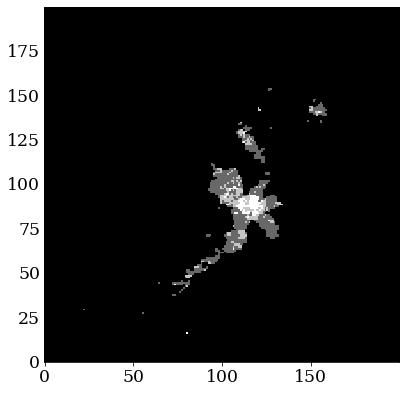

In [249]:
import matplotlib.cm as cm
fig = plt.figure()
ax2 = fig.add_subplot(121)
ax2.imshow(Image, interpolation='nearest', cmap=cm.Greys_r)
ax2.invert_yaxis()
#plt.ylim(25,175)

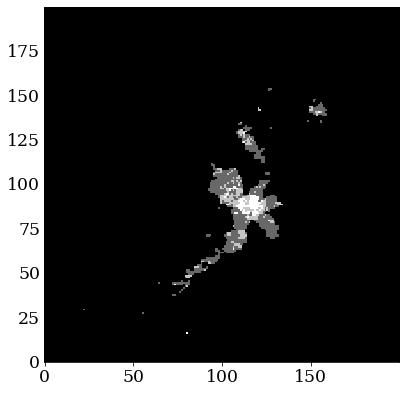

In [250]:
import matplotlib.cm as cm
fig = plt.figure()
ax2 = fig.add_subplot(121)
ax2.imshow(Image, interpolation='nearest', cmap=cm.Greys_r)
ax2.invert_yaxis()
#plt.ylim(25,175)
#plt.xlim(50, 175)

#plt.ylim(80,120)
#plt.xlim(100,110)

In [280]:
Line_width_min = bestparam[0, :, :] * np.nan
Vel_min_width = bestparam[0, :, :] * np.nan
Amp_min = bestparam[0, :, :] * np.nan
Image_min = np.zeros(shape=(zoom_size, zoom_size))
width_narrow = 5
overlaps = 0

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
        if Image[i, j] == 1.0 :
            
            if 7 < bestparam[1, i, j] < 9 and bestparam[2, i, j] < width_narrow :
                
                Line_width_min[i, j] = bestparam[2, i, j]
                Vel_min_width[i, j] = bestparam[1, i, j]
                Amp_min[i, j] = bestparam[0, i, j]
                Image_min[i, j] = Image[i, j]
                
        if Image[i, j] == 2.0 :
            
            if 7 < bestparam[4, i, j] < 9 and bestparam[5, i, j] < width_narrow and bestparam[3, i, j] > bestparam[0, i, j] :
                
                Line_width_min[i, j] = bestparam[5, i, j]
                Vel_min_width[i, j] = bestparam[4, i, j]
                Amp_min[i, j] = bestparam[3, i, j]
                Image_min[i, j] = Image[i, j]
                
                if 7 < bestparam[1, i, j] < 9 and bestparam[2, i, j] < width_narrow :
                    
                    overlaps +=1
                
        if Image[i, j] == 3.0 :
            
            if 7 < bestparam[4, i, j] < 9 and bestparam[5, i, j] < width_narrow and bestparam[3, i, j] > bestparam[0, i, j] :
                
                Line_width_min[i, j] = bestparam[5, i, j]
                Vel_min_width[i, j] = bestparam[4, i, j]
                Amp_min[i, j] = bestparam[3, i, j]
                Image_min[i, j] = Image[i, j]
                
                if 7 < bestparam[7, i, j] < 9 and bestparam[8, i, j] < width_narrow and bestparam[6, i, j] > bestparam[3, i, j] :
                    
                    Line_width_min[i, j] = bestparam[8, i, j]
                    Vel_min_width[i, j] = bestparam[7, i, j]
                    Amp_min[i, j] = bestparam[6, i, j]
                    
                    overlaps +=1
                    
            elif 7 < bestparam[7, i, j] < 9 and bestparam[8, i, j] < width_narrow and bestparam[6, i, j] > bestparam[0, i, j] :
                
                Line_width_min[i, j] = bestparam[8, i, j]
                Vel_min_width[i, j] = bestparam[7, i, j]
                Amp_min[i, j] = bestparam[6, i, j]
                Image_min[i, j] = Image[i, j]
                
                if 7 < bestparam[1, i, j] < 9 and bestparam[2, i, j] < width_narrow :
                    
                    overlaps +=1

In [252]:
overlaps

31

In [519]:
Line_width_min_blue = bestparam[0, :, :] * np.nan
Vel_min_width_blue = bestparam[0, :, :] * np.nan
Amp_min_blue = bestparam[0, :, :] * np.nan
Image_min_blue = np.zeros(shape=(zoom_size, zoom_size))
width_narrow = 5
vel_min = 7
overlaps = 0

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
        if vel_min < bestparam[1, i, j] < vlsr and bestparam[2, i, j] < width_narrow :
                
            Line_width_min_blue[i, j] = bestparam[2, i, j]
            Vel_min_width_blue[i, j] = bestparam[1, i, j]
            Amp_min_blue[i, j] = bestparam[0, i, j]
            Image_min_blue[i, j] = Image[i, j]
                
        if Image[i, j] == 2.0 :
            
            if vel_min < bestparam[4, i, j] < vlsr and bestparam[5, i, j] < width_narrow :
                
                if (bestparam[1, i, j] < vlsr and bestparam[4, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_min_blue[i, j] = bestparam[5, i, j]
                    Vel_min_width_blue[i, j] = bestparam[4, i, j]
                    Amp_min_blue[i, j] = bestparam[3, i, j]
                    Image_min_blue[i, j] = Image[i, j]
                
                    if vel_min < bestparam[1, i, j] < vlsr and bestparam[2, i, j] < width_narrow :
                    
                        overlaps +=1
                
        if Image[i, j] == 3.0 :
            
            if vel_min < bestparam[4, i, j] < vlsr and bestparam[5, i, j] < width_narrow :
                
                if (bestparam[1, i, j] < vlsr and bestparam[4, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_min_blue[i, j] = bestparam[5, i, j]
                    Vel_min_width_blue[i, j] = bestparam[4, i, j]
                    Amp_min_blue[i, j] = bestparam[3, i, j]
                    Image_min_blue[i, j] = Image[i, j]
                
                    if vel_min < bestparam[7, i, j] < vlsr and bestparam[8, i, j] < width_narrow and bestparam[7, i, j] > bestparam[1, i, j] :
                    
                        Line_width_min_blue[i, j] = bestparam[8, i, j]
                        Vel_min_width_blue[i, j] = bestparam[7, i, j]
                        Amp_min_blue[i, j] = bestparam[6, i, j]
                    
                    overlaps +=1
                    
            elif vel_min < bestparam[7, i, j] < vlsr and bestparam[8, i, j] < width_narrow :
                
                if (bestparam[1, i, j] < vlsr and bestparam[7, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_min_blue[i, j] = bestparam[8, i, j]
                    Vel_min_width_blue[i, j] = bestparam[7, i, j]
                    Amp_min_blue[i, j] = bestparam[6, i, j]
                    Image_min_blue[i, j] = Image[i, j]
                
                    if vel_min < bestparam[1, i, j] < vlsr and bestparam[2, i, j] < width_narrow :
                    
                        overlaps +=1

In [520]:
overlaps

99

In [582]:
Line_width_min_red = bestparam[0, :, :] * np.nan
Vel_min_width_red = bestparam[0, :, :] * np.nan
Amp_min_red = bestparam[0, :, :] * np.nan
Image_min_red = np.zeros(shape=(zoom_size, zoom_size))
width_narrow = 5
vel_max = 9.4
overlaps = 0

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
            
        if vel_max > bestparam[1, i, j] > vlsr and bestparam[2, i, j] < width_narrow :
                
            Line_width_min_red[i, j] = bestparam[2, i, j]
            Vel_min_width_red[i, j] = bestparam[1, i, j]
            Amp_min_red[i, j] = bestparam[0, i, j]
            Image_min_red[i, j] = Image[i, j]
                
        if Image[i, j] == 2.0 :
            
            if vel_max > bestparam[4, i, j] > vlsr and bestparam[5, i, j] < width_narrow :
                
                if (bestparam[1, i, j] > vlsr and bestparam[4, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_min_red[i, j] = bestparam[5, i, j]
                    Vel_min_width_red[i, j] = bestparam[4, i, j]
                    Amp_min_red[i, j] = bestparam[3, i, j]
                    Image_min_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[1, i, j] > vlsr and bestparam[2, i, j] < width_narrow :
                    
                        overlaps +=1
                
        if Image[i, j] == 3.0 :
            
            if vel_max > bestparam[4, i, j] > vlsr and bestparam[5, i, j] < width_narrow :
                
                if (bestparam[1, i, j] > vlsr and bestparam[4, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_min_red[i, j] = bestparam[5, i, j]
                    Vel_min_width_red[i, j] = bestparam[4, i, j]
                    Amp_min_red[i, j] = bestparam[3, i, j]
                    Image_min_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[7, i, j] > vlsr and bestparam[8, i, j] < width_narrow :
                        
                        if bestparam[7, i, j] < bestparam[4, i, j] :
                    
                            Line_width_min_red[i, j] = bestparam[8, i, j]
                            Vel_min_width_red[i, j] = bestparam[7, i, j]
                            Amp_min_red[i, j] = bestparam[6, i, j]
                    
                    overlaps +=1
                    
            elif vel_max > bestparam[7, i, j] > vlsr and bestparam[8, i, j] < width_narrow :
                
                if (bestparam[1, i, j] > vlsr and bestparam[7, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_min_red[i, j] = bestparam[8, i, j]
                    Vel_min_width_red[i, j] = bestparam[7, i, j]
                    Amp_min_red[i, j] = bestparam[6, i, j]
                    Image_min_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[1, i, j] > vlsr and bestparam[2, i, j] < width_narrow :
                    
                        overlaps +=1

In [417]:
Line_width_min_red = bestparam[0, :, :] * np.nan
Vel_min_width_red = bestparam[0, :, :] * np.nan
Amp_min_red = bestparam[0, :, :] * np.nan
Image_min_red = np.zeros(shape=(zoom_size, zoom_size))
width_narrow = 1.4
vel_max = 10
overlaps = 0

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
            
        if vel_max > bestparam[1, i, j] > vlsr:
                
            Line_width_min_red[i, j] = bestparam[2, i, j]
            Vel_min_width_red[i, j] = bestparam[1, i, j]
            Amp_min_red[i, j] = bestparam[0, i, j]
            Image_min_red[i, j] = Image[i, j]
                
        if Image[i, j] == 2.0 :
            
            if vel_max > bestparam[4, i, j] > vlsr :
                
                if (bestparam[1, i, j] > vlsr and bestparam[4, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_min_red[i, j] = bestparam[5, i, j]
                    Vel_min_width_red[i, j] = bestparam[4, i, j]
                    Amp_min_red[i, j] = bestparam[3, i, j]
                    Image_min_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[1, i, j] > vlsr :
                    
                        overlaps +=1
                
        if Image[i, j] == 3.0 :
            
            if vel_max > bestparam[4, i, j] > vlsr :
                
                if (bestparam[1, i, j] > vlsr and bestparam[4, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_min_red[i, j] = bestparam[5, i, j]
                    Vel_min_width_red[i, j] = bestparam[4, i, j]
                    Amp_min_red[i, j] = bestparam[3, i, j]
                    Image_min_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[7, i, j] > vlsr :
                        
                        if bestparam[7, i, j] < bestparam[4, i, j] :
                    
                            Line_width_min_red[i, j] = bestparam[8, i, j]
                            Vel_min_width_red[i, j] = bestparam[7, i, j]
                            Amp_min_red[i, j] = bestparam[6, i, j]
                    
                    overlaps +=1
                    
            elif vel_max > bestparam[7, i, j] > vlsr :
                
                if (bestparam[1, i, j] > vlsr and bestparam[7, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_min_red[i, j] = bestparam[8, i, j]
                    Vel_min_width_red[i, j] = bestparam[7, i, j]
                    Amp_min_red[i, j] = bestparam[6, i, j]
                    Image_min_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[1, i, j] > vlsr :
                    
                        overlaps +=1

In [522]:
overlaps

29

In [258]:
Line_width_max = bestparam[0, :, :] * np.nan
Vel_max_width = bestparam[0, :, :] * np.nan
Amp_max = bestparam[0, :, :] * np.nan
Image_max = np.zeros(shape=(zoom_size, zoom_size))
width_broad = 0.8

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
            
        if bestparam[2, i, j] > width_broad and 10 > bestparam[1, i, j] > 7 :
                
            Line_width_max[i, j] = bestparam[2, i, j]
            Vel_max_width[i, j] = bestparam[1, i, j]
            Amp_max[i, j] = bestparam[0, i, j]
            Image_max[i, j] = Image[i, j]
            
        if Image[i, j] == 2.0 :
            
            if bestparam[5, i, j] > width_broad and 10 > bestparam[4, i, j] > 7 and bestparam[3, i, j] > bestparam[0, i, j] :
                
                Line_width_max[i, j] = bestparam[5, i, j]
                Vel_max_width[i, j] = bestparam[4, i, j]
                Amp_max[i, j] = bestparam[3, i, j]
                Image_max[i, j] = Image[i, j]
                
        if Image[i, j] == 3.0 :
            
            if bestparam[5, i, j] > width_broad and 10 > bestparam[4, i, j] > 7 and bestparam[3, i, j] > bestparam[0, i, j] :
                
                Line_width_max[i, j] = bestparam[5, i, j]
                Vel_max_width[i, j] = bestparam[4, i, j]
                Amp_max[i, j] = bestparam[3, i, j]
                Image_max[i, j] = Image[i, j]
                
                if bestparam[8, i, j] > width_broad and 10 > bestparam[7, i, j] > 7 and bestparam[6, i, j] > bestparam[3, i, j] :
                
                    Line_width_max[i, j] = bestparam[8, i, j]
                    Vel_max_width[i, j] = bestparam[7, i, j]
                    Amp_max[i, j] = bestparam[6, i, j]
                    Image_max[i, j] = Image[i, j]
                
            elif bestparam[8, i, j] > width_broad and 10 > bestparam[7, i, j] > 7 and bestparam[6, i, j] > bestparam[0, i, j] :
                
                Line_width_max[i, j] = bestparam[8, i, j]
                Vel_max_width[i, j] = bestparam[7, i, j]
                Amp_max[i, j] = bestparam[6, i, j]
                Image_max[i, j] = Image[i, j]

In [406]:
Line_width_max_blue = bestparam[0, :, :] * np.nan
Vel_max_width_blue = bestparam[0, :, :] * np.nan
Amp_max_blue = bestparam[0, :, :] * np.nan
Image_max_blue = np.zeros(shape=(zoom_size, zoom_size))
width_narrow = 1
vel_max = 7
overlaps = 0

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
            
        if vel_max < bestparam[1, i, j] < vlsr and bestparam[2, i, j] > width_narrow :
                
            Line_width_max_blue[i, j] = bestparam[2, i, j]
            Vel_max_width_blue[i, j] = bestparam[1, i, j]
            Amp_max_blue[i, j] = bestparam[0, i, j]
            Image_max_blue[i, j] = Image[i, j]
                
        if Image[i, j] == 2.0 :
            
            if vel_max < bestparam[4, i, j] < vlsr and bestparam[5, i, j] > width_narrow :
                
                if (bestparam[1, i, j] < vlsr and bestparam[4, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_max_blue[i, j] = bestparam[5, i, j]
                    Vel_max_width_blue[i, j] = bestparam[4, i, j]
                    Amp_max_blue[i, j] = bestparam[3, i, j]
                    Image_max_blue[i, j] = Image[i, j]
                
                    if vel_max < bestparam[1, i, j] < vlsr and bestparam[2, i, j] > width_narrow :
                    
                        overlaps +=1
                
        if Image[i, j] == 3.0 :
            
            if vel_max < bestparam[4, i, j] < vlsr and bestparam[5, i, j] > width_narrow :
                
                if (bestparam[1, i, j] < vlsr and bestparam[4, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_max_blue[i, j] = bestparam[5, i, j]
                    Vel_max_width_blue[i, j] = bestparam[4, i, j]
                    Amp_max_blue[i, j] = bestparam[3, i, j]
                    Image_max_blue[i, j] = Image[i, j]
                
                    if vel_max < bestparam[7, i, j] < vlsr and bestparam[8, i, j] > width_narrow and bestparam[7, i, j] > bestparam[1, i, j] :
                    
                        Line_width_max_blue[i, j] = bestparam[8, i, j]
                        Vel_max_width_blue[i, j] = bestparam[7, i, j]
                        Amp_max_blue[i, j] = bestparam[6, i, j]
                    
                    overlaps +=1
                    
            elif vel_max < bestparam[7, i, j] < vlsr and bestparam[8, i, j] > width_narrow :
                
                if (bestparam[1, i, j] < vlsr and bestparam[7, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_max_blue[i, j] = bestparam[8, i, j]
                    Vel_max_width_blue[i, j] = bestparam[7, i, j]
                    Amp_max_blue[i, j] = bestparam[6, i, j]
                    Image_max_blue[i, j] = Image[i, j]
                
                    if vel_max < bestparam[1, i, j] < vlsr and bestparam[2, i, j] > width_narrow :
                    
                        overlaps +=1

In [407]:
overlaps

27

In [400]:
Line_width_max_red = bestparam[0, :, :] * np.nan
Vel_max_width_red = bestparam[0, :, :] * np.nan
Amp_max_red = bestparam[0, :, :] * np.nan
Image_max_red = np.zeros(shape=(zoom_size, zoom_size))
width_narrow = 1
vel_max = 10
overlaps = 0

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
            
        if vel_max > bestparam[1, i, j] > vlsr and bestparam[2, i, j] > width_narrow :
                
            Line_width_max_red[i, j] = bestparam[2, i, j]
            Vel_max_width_red[i, j] = bestparam[1, i, j]
            Amp_max_red[i, j] = bestparam[0, i, j]
            Image_max_red[i, j] = Image[i, j]
                
        if Image[i, j] == 2.0 :
            
            if vel_max > bestparam[4, i, j] > vlsr and bestparam[5, i, j] > width_narrow :
                
                if (bestparam[1, i, j] > vlsr and bestparam[4, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_max_red[i, j] = bestparam[5, i, j]
                    Vel_max_width_red[i, j] = bestparam[4, i, j]
                    Amp_max_red[i, j] = bestparam[3, i, j]
                    Image_max_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[1, i, j] > vlsr and bestparam[2, i, j] > width_narrow :
                    
                        overlaps +=1
                
        if Image[i, j] == 3.0 :
            
            if vel_max > bestparam[4, i, j] > vlsr and bestparam[5, i, j] > width_narrow :
                
                if (bestparam[1, i, j] > vlsr and bestparam[4, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_max_red[i, j] = bestparam[5, i, j]
                    Vel_max_width_red[i, j] = bestparam[4, i, j]
                    Amp_max_red[i, j] = bestparam[3, i, j]
                    Image_max_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[7, i, j] > vlsr and bestparam[8, i, j] > width_narrow :
                        
                        if bestparam[7, i, j] < bestparam[4, i, j] :
                    
                            Line_width_max_red[i, j] = bestparam[8, i, j]
                            Vel_max_width_red[i, j] = bestparam[7, i, j]
                            Amp_max_red[i, j] = bestparam[6, i, j]
                    
                    overlaps +=1
                    
            elif vel_max > bestparam[7, i, j] > vlsr and bestparam[8, i, j] > width_narrow :
                
                if (bestparam[1, i, j] > vlsr and bestparam[7, i, j] < bestparam[1, i, j]) or bestparam[1, i, j] < vlsr :
                
                    Line_width_max_red[i, j] = bestparam[8, i, j]
                    Vel_max_width_red[i, j] = bestparam[7, i, j]
                    Amp_max_red[i, j] = bestparam[6, i, j]
                    Image_max_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[1, i, j] > vlsr and bestparam[2, i, j] > width_narrow :
                    
                        overlaps +=1

In [262]:
overlaps

20

In [263]:
Line_width_other = bestparam[0, :, :] * np.nan
Vel_other_width = bestparam[0, :, :] * np.nan
Amp_other = bestparam[0, :, :] * np.nan
Image_other = np.zeros(shape=(zoom_size, zoom_size))
width_other = 0.8

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
            
        if bestparam[2, i, j] != Line_width_max[i, j] and bestparam[2, i, j] != Line_width_min_blue[i, j] and bestparam[2, i, j] != Line_width_min_red[i, j] :
                
            Line_width_other[i, j] = bestparam[2, i, j]
            Vel_other_width[i, j] = bestparam[1, i, j]
            Amp_other[i, j] = bestparam[0, i, j]
            Image_other[i, j] = Image[i, j]
            
        if Image[i, j] == 2.0 :
            
            if bestparam[5, i, j] != Line_width_max[i, j] and bestparam[5, i, j] != Line_width_min_blue[i, j] and bestparam[5, i, j] != Line_width_min_red[i, j] and bestparam[3, i, j] > bestparam[0, i, j] :
                
                Line_width_other[i, j] = bestparam[5, i, j]
                Vel_other_width[i, j] = bestparam[4, i, j]
                Amp_other[i, j] = bestparam[3, i, j]
                Image_other[i, j] = Image[i, j]
                
        if Image[i, j] == 3.0 :
            
            if bestparam[5, i, j] != Line_width_max[i, j] and bestparam[5, i, j] != Line_width_min_blue[i, j] and bestparam[5, i, j] != Line_width_min_red[i, j] and bestparam[3, i, j] > bestparam[0, i, j] :
                
                Line_width_other[i, j] = bestparam[5, i, j]
                Vel_other_width[i, j] = bestparam[4, i, j]
                Amp_other[i, j] = bestparam[3, i, j]
                Image_other[i, j] = Image[i, j]
                
                if bestparam[8, i, j] != Line_width_max[i, j] and bestparam[8, i, j] != Line_width_min_blue[i, j] and bestparam[8, i, j] != Line_width_min_red[i, j] and bestparam[6, i, j] > bestparam[3, i, j] :
                
                    Line_width_other[i, j] = bestparam[8, i, j]
                    Vel_other_width[i, j] = bestparam[7, i, j]
                    Amp_other[i, j] = bestparam[6, i, j]
                    Image_other[i, j] = Image[i, j]
                
            elif bestparam[8, i, j] != Line_width_max[i, j] and bestparam[8, i, j] != Line_width_min_blue[i, j] and bestparam[8, i, j] != Line_width_min_red[i, j] and bestparam[6, i, j] > bestparam[0, i, j] :
                
                Line_width_other[i, j] = bestparam[8, i, j]
                Vel_other_width[i, j] = bestparam[7, i, j]
                Amp_other[i, j] = bestparam[6, i, j]
                Image_other[i, j] = Image[i, j]

In [264]:
file_dv_SO_min_width_blue = 'Documents/SO/B335_SO_vlsr_5snr_min_width_blue.fits'
file_dv_SO_min_width_red = 'Documents/SO/B335_SO_vlsr_5snr_min_width_red.fits'
file_vc_SO_min_vel_blue = 'Documents/SO/B335_SO_vlsr_5snr_min_vel_blue.fits'
file_vc_SO_min_vel_red = 'Documents/SO/B335_SO_vlsr_5snr_min_vel_red.fits'

file_dv_SO_max_width_blue = 'Documents/SO/B335_SO_vlsr_5snr_max_width_blue.fits'
file_dv_SO_max_width_red = 'Documents/SO/B335_SO_vlsr_5snr_max_width_red.fits'
file_vc_SO_max_vel_blue = 'Documents/SO/B335_SO_vlsr_5snr_max_vel_blue.fits'
file_vc_SO_max_vel_red = 'Documents/SO/B335_SO_vlsr_5snr_max_vel_red.fits'


file_dv_SO_max_width = 'Documents/SO/B335_SO_vlsr_5snr_max_width.fits'
file_vc_SO_min_vel = 'Documents/SO/B335_SO_vlsr_5snr_min_vel.fits'
file_vc_SO_max_vel = 'Documents/SO/B335_SO_vlsr_5snr_max_vel.fits'
file_Image = 'Documents/SO/B335_SO_howmanycomp.fits'
file_Image_max = 'Documents/SO/B335_SO_howmanycomp_broad.fits'
file_Image_min = 'Documents/SO/B335_SO_howmanycomp_narrow.fits'

file_dv_SO_other_width = 'Documents/SO/B335_SO_vlsr_5snr_other_width.fits'
file_vc_SO_other_vel = 'Documents/SO/B335_SO_vlsr_5snr_other_vel.fits'
file_Image_other = 'Documents/SO/B335_SO_howmanycomp_other.fits'

In [583]:
file = 'Documents/SO/Spec_SO_fit_5snr_3comp_test.fits'
file_par = 'Documents/SO/Spec_SO_fit_5snr_3comp_014kms copie.fits'
data, hd = fits.getdata(file_par, header=True)
hd_2d = hd.copy()
key_list = ['NAXIS3', 'CRPIX3', 'SPECSYS', 'CDELT3', 'CUNIT3', 'CTYPE3', 'CRVAL3']
for key_i in key_list:
    hd_2d.remove(key_i)
hd_2d['NAXIS'] = 2
hd_2d['WCSAXES'] = 2
hd_2d['BITPIX'] = 8
hd_2d['BUNIT'] = 'km/s'

data[:,:,:] = 0.0

for n in range(zoom_size) : 
    
    i = n + 500
    
    for p in range(zoom_size) :
        
        j = p + 500
        
        data[9, i, j] = Image[n, p]
        
        data[10, i, j] = Line_width_max_red[n, p]
        
        
        
            
        data[8,i,j] = Vel_min_width_blue[n, p]
        data[7,i,j] = Vel_min_width_red[n, p]
        
        data[4,i,j] = Line_width_other[n, p]
        data[3,i,j] = Vel_other_width[n, p]
        
            
        data[2,i,j] = Vel_max_width_blue[n, p]
        data[1,i,j] = Vel_max_width_red[n, p]
        
        data[6,i,j] = Line_width_min_blue[n, p]
        data[5,i,j] = Line_width_min_red[n, p]

            
fits.writeto(file_vc_SO_other_vel, np.squeeze(data[3, :, :]), hd_2d, overwrite=True)    
fits.writeto(file_dv_SO_other_width, np.squeeze(data[4, :, :]), hd_2d, overwrite=True)  

fits.writeto(file_dv_SO_min_width_blue, np.squeeze(data[6, :, :]), hd_2d, overwrite=True)
fits.writeto(file_dv_SO_min_width_red, np.squeeze(data[5, :, :]), hd_2d, overwrite=True)

fits.writeto(file_dv_SO_max_width_red, np.squeeze(data[10, :, :]), hd_2d, overwrite=True)

fits.writeto(file_vc_SO_min_vel_blue, np.squeeze(data[8,:,:]), hd_2d, overwrite=True)
fits.writeto(file_vc_SO_min_vel_red, np.squeeze(data[7,:,:]), hd_2d, overwrite=True)

fits.writeto(file_vc_SO_max_vel_blue, np.squeeze(data[2,:,:]), hd_2d, overwrite=True)
fits.writeto(file_vc_SO_max_vel_red, np.squeeze(data[1,:,:]), hd_2d, overwrite=True)


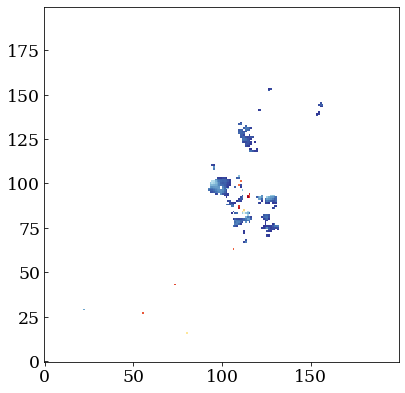

In [425]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax2 = fig.add_subplot(122)
ax2.imshow(Vel_min_width_red, interpolation='nearest', cmap=cm.RdYlBu_r)
ax2.invert_yaxis()
#plt.ylim(85,90)
#plt.xlim(110, 125)

#plt.ylim(80,100)
#plt.xlim(100,120)

In [395]:
bestparam[:,88,120]

array([1.37247152e-02, 7.12057972e+00, 1.53749432e+00, 1.08213949e-02,
       8.21305039e+00, 6.36280675e-01, 2.39868922e-03, 1.05205850e+01,
       5.10704553e-01, 1.35088403e-03, 2.72740770e-01, 1.17759766e-01,
       2.64732299e-03, 4.99780024e-02, 9.29023620e-02])

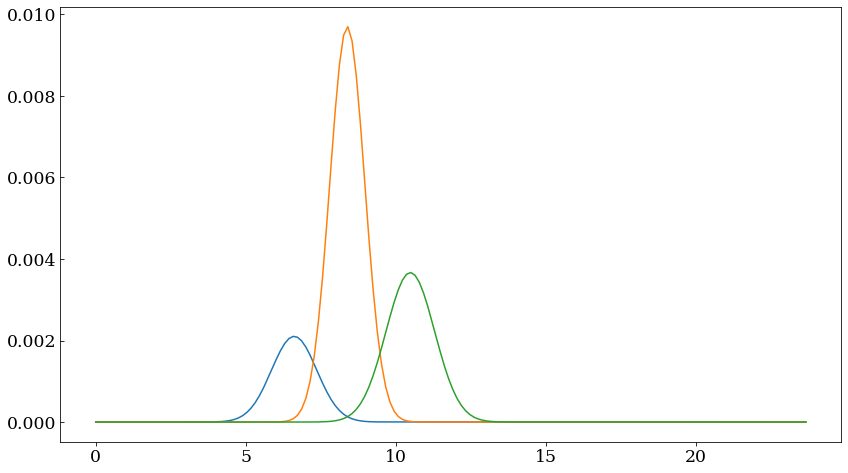

In [270]:
plt.plot(Cube.spectral_axis.value, Gaussian(Cube.spectral_axis.value, bestparam[0,90,109], bestparam[1,90,109], bestparam[2,90,109]))
plt.plot(Cube.spectral_axis.value, Gaussian(Cube.spectral_axis.value, bestparam[3,90,109], bestparam[4,90,109], bestparam[5,90,109]))
plt.plot(Cube.spectral_axis.value, Gaussian(Cube.spectral_axis.value, bestparam[6,90,109], bestparam[7,90,109], bestparam[8,90,109]))

In [305]:
cleaned_min_width = []
cleaned_max_width = []
cleaned_min_vel = []
cleaned_max_vel = []

for i in range(len(Line_width_max)) :
    
    for j in range(len(Line_width_max)) :
        
        if np.isnan(Line_width_min[i, j]) == False :
            
            cleaned_min_width.append(np.abs(Line_width_min[i, j]))
        
        if np.isnan(Line_width_max[i, j]) == False :
            
            cleaned_max_width.append(np.abs(Line_width_max[i, j]))
            
        if np.isnan(Vel_max_width[i, j]) == False :
            
            cleaned_max_vel.append(np.abs(Vel_max_width[i, j]))
            
        if np.isnan(Vel_min_width[i, j]) == False :
            
            cleaned_min_vel.append(np.abs(Vel_min_width[i, j]))

In [306]:
kde = gaussian_kde(cleaned_min_width)

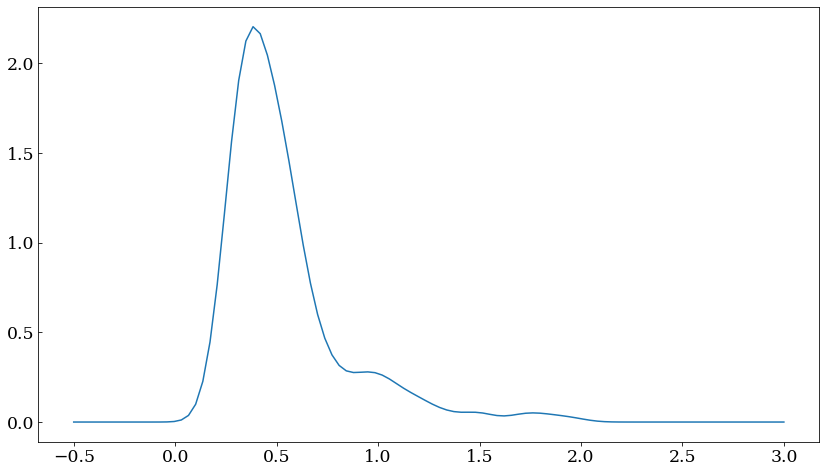

In [308]:
t = np.linspace(-0.5,3,100)

plt.plot(t,kde.pdf(t))

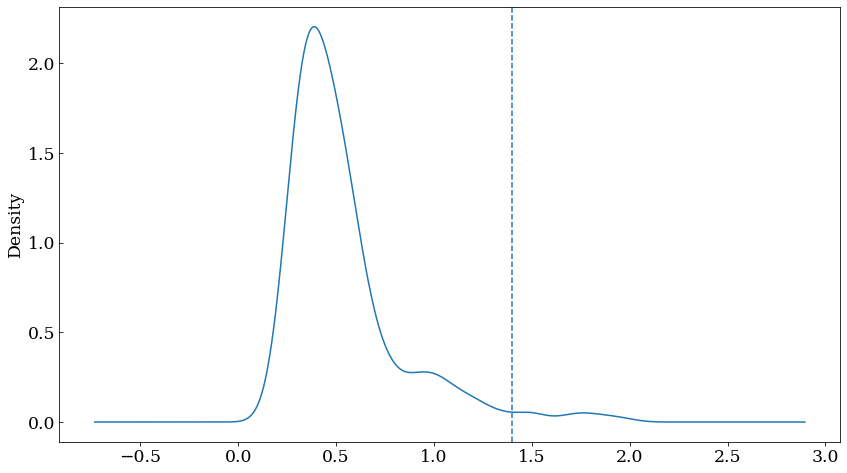

In [309]:
s = pd.Series(cleaned_min_width)
#t = pd.Series(cleaned_max_width)
s.plot.kde()
#t.plot.kde()
plt.axvline(1.4, linestyle = 'dashed')

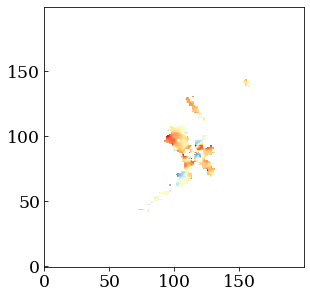

In [551]:
fig = plt.figure()

#ax = fig.add_subplot(221)
#ax.imshow(Line_width_max, cmap=cm.Reds)
#ax.invert_yaxis()
#ax2 = fig.add_subplot(223)
#ax2.imshow(Line_width_min, cmap=cm.Reds)
#ax2.invert_yaxis()

ax3 = fig.add_subplot(222)
ax3.imshow(Vel_min_width, cmap=cm.RdYlBu_r)
ax3.invert_yaxis()

plt.tight_layout()

In [574]:
width = []

for i in range(zoom_size) :
    
    for j in range(zoom_size) :
        
        if Image[i, j] == 1.0 :
            
            if bestparam[2, i, j] > 2 :
                
                width.append(bestparam[2, i, j])
                print(i, j)
                
        elif Image[i, j] == 2.0 :
            
            if bestparam[2, i, j] > 2 :
                
                width.append(bestparam[2, i, j])
                print(i, j)
                
            if bestparam[5, i, j] > 2 :
                
                width.append(bestparam[5, i, j])
                print(i, j)
                
        elif Image[i, j] == 3.0 :
            
            if bestparam[2, i, j] > 2 :
                
                width.append(bestparam[2, i, j])
                print(i, j)
                
            if bestparam[5, i, j] > 2 :
                
                width.append(bestparam[5, i, j])
                print(i, j)
                
            if bestparam[8, i, j] > 2 :
                
                width.append(bestparam[8, i, j])
                print(i, j)

84 111
86 111
86 112
86 113
91 104
91 105
92 101
92 102
92 104
93 103
95 118
97 105
127 112


In [555]:
width

[5.740118224486489]

In [275]:
data = np.zeros(shape=(170, 1200, 1200))

for n in range(zoom_size) :
    
    i = n + i_zoom
    
    for p in range(zoom_size) :
        
        j = p + j_zoom
        
        if Image[n, p] == 1.0 :
            
            data[:, i, j] =  Gaussian(Cube.spectral_axis.value, 
                                      A=bestparam[0, n, p], 
                                      mu=bestparam[1, n, p], 
                                      width=bestparam[2, n, p])
            
        elif Image[n, p] == 2.0 :
            
            data[:, i, j] =  Gaussian_2comp(Cube.spectral_axis.value, 
                                      A1=bestparam[0, n, p], 
                                      mu1=bestparam[1, n, p], 
                                      width1=bestparam[2, n, p],
                                      A2=bestparam[3, n, p], 
                                      mu2=bestparam[4, n, p], 
                                      width2=bestparam[5, n, p])
            
        elif Image[n, p] == 3.0 :
            
            data[:, i, j] =  Gaussian_3comp(Cube.spectral_axis.value, 
                                      A1=bestparam[0, n, p], 
                                      mu1=bestparam[1, n, p], 
                                      width1=bestparam[2, n, p],
                                      A2=bestparam[3, n, p], 
                                      mu2=bestparam[4, n, p], 
                                      width2=bestparam[5, n, p],
                                      A3=bestparam[6, n, p], 
                                      mu3=bestparam[7, n, p], 
                                      width3=bestparam[8, n, p])

In [276]:
data = Gaussian(Cube.spectral_axis.value, A=data_1comp[0,600,600], mu =data_1comp[1,600,600], width=data_1comp[2,600,600])

In [277]:
wcs = WCS(file_cube)

In [393]:
#Cube_test = SpectralCube(data=data, wcs=wcs)

In [ ]:
Cube_test.write('Documents/SO/B335_SO_Gaussian_cube.fits', overwrite=True)

In [460]:
dv = 1000*u.m/u.s
m = 48.06*1.66054e-27*u.kg

In [461]:
T = (dv**2 * m)/(8*np.log(2)*constants.k_B)

In [463]:
T.to(u.K)

<Quantity 1042.39993911 K>